# Zonally Averaged Overturning Circulation

This notebook shows a simple example of calculation the zonally averaged global meridional overturning circulation - in density space - using output from either `MOM5` or `MOM6`.

**Requirements:** The `conda/analysis3` (or later) module on ARE. I recommend an ARE session with more than 14 cores to make these computations.

**Firstly,** load in the requisite libraries:

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client
import cf_xarray as cfxr

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34659,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:43733,Total threads: 2
Dashboard: /proxy/39113/status,Memory: 9.14 GiB
Nanny: tcp://127.0.0.1:35203,


**At this stage**, you should denote whether the experiment uses output from `MOM5` or `MOM6`. 
This notebook is designed to use `cf-xarray` and a dictionary of `querying.getvar` arguments to load the correct variables irrespective of the model. 

In [3]:
session = cc.database.create_session()
model = 'mom6'

**Next,** choose an experiment. This can be any resolution; if you are using a MOM5-based run it can be with or without Gent-McWilliams eddy parameterisation. In this case, we are choosing to limit ourselves to just the last 20 years of the 0.25° control simulation. If you want to increase the resolution or integrate over a longer time you might need more resources!

In [4]:
psi_args = {
    "mom5": {
        "expt": "025deg_jra55v13_iaf_gmredi6",
        "variable": "ty_trans_rho",
        "start_time": "2238-01-01",
    },
    "mom6": {
        "expt": "OM4_025.JRA_RYF",
        "variable": "vmo",
        "start_time": "1975-01-01",
        "frequency": "1 monthly",
        "attrs": {"cell_methods": "rho2_l:sum yq:point xh:sum time: mean"},
    }
}
expt = psi_args[model]["expt"]
start_time = psi_args[model]["start_time"]

MOM5: Load up `ty_trans_rho` - and sum zonally.
Also, if there is a `ty_trans_rho_gm` variable saved, assume that GM is switched on and load that as well. 

In [5]:
psi = cc.querying.getvar(session=session, **psi_args[model])
psi = psi.cf.sum("longitude")

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_rho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time=start_time)
    psiGM = psiGM.cf.sum("longitude")
else:
    GM = False

/home/157/ahg157/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
cannot import name 'NDArray' from 'numpy.typing' (/home/157/ahg157/.local/lib/python3.9/site-packages/numpy/typing/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/157/ahg157/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
cannot import name 'NDArray' from 'numpy.typing' (/home/157/ahg157/.local/lib/python3.9/site-packages/numpy/typing/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/157/ahg157/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
cannot import name 'NDArray' from 'numpy.typing' (/home/157/ahg157/.local/lib/python3.9/site-packages/numpy/typing/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarn

Most ACCESS-OM2 and MOM6 simulations save transport with units of kg/s - convert to Sv:

In [6]:
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)

Now, cumulatively sum the transport in the vertical. Note that in MOM5 the `ty_trans_rho_GM` variable is computed differently and **does not** require summing in the vertical. Once the calculation has been laid out, we then load the variable to force the computation to occur.

In [7]:
psi_avg = psi.cf.cumsum("vertical").mean("time") - psi.cf.sum("vertical").mean("time")
if GM:
    psi_avg = psi_avg + psiGM.cf.mean("time")
    
psi_avg.load();

Now we are ready to plot. We usually plot the streamfunction over a reduced range of density levels to highlight the deep ocean contribution...

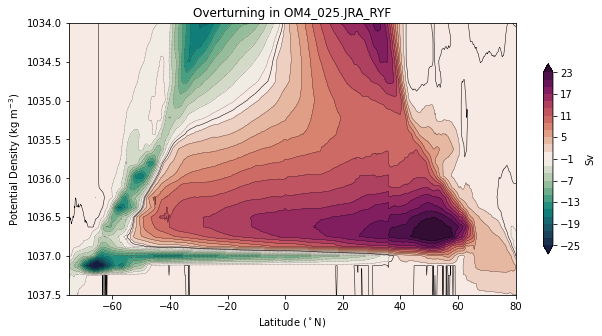

In [8]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-25,25,2)
psi_avg.plot.contourf(cmap=cm.cm.curl, levels=clev, extend='both', cbar_kwargs={'shrink':0.7,'label':'Sv'})
psi_avg.plot.contour(levels=clev, colors='k', linewidths=0.25)
psi_avg.plot.contour(levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title(f'Overturning in {expt}');

Alternatively, you may want to stretch your axes to minimise the visual impact of the surface circulation, while showing the full-depth ocean.

In [9]:
scfac = 4  ## A power to set the stretching
psi_avg_plot = psi_avg.assign_coords(
    {
        psi_avg.cf["vertical"].name: (psi_avg.cf["vertical"] - 1028)**4
    }
)

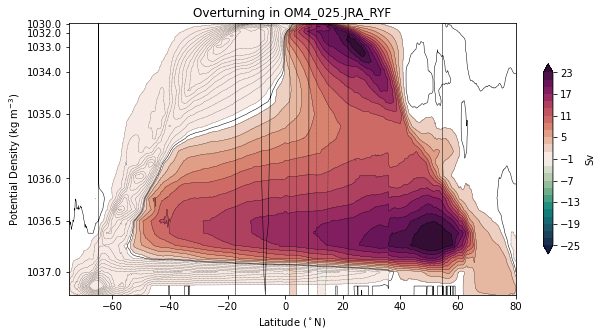

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])

psi_avg_plot.plot.contourf(cmap=cm.cm.curl, levels=clev, extend='both',cbar_kwargs={'shrink':0.7,'label':'Sv'})
psi_avg_plot.plot.contour(levels=clev, colors='k', linewidths=0.25)
psi_avg_plot.plot.contour(levels=[0.0,], colors='k', linewidths=0.5)

plt.gca().set_yticks((yticks-1028)**scfac)
plt.gca().set_yticklabels(yticks)
plt.gca().set_ylim([0.5**scfac, 9.2**scfac])
plt.gca().invert_yaxis()

plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title(f'Overturning in {expt}');

**Notes:**
 * We have not included the submesoscale contribution to the meridional transport in these calculations, as it tends to be relatively unimportant for the deep circulation, which we where we are primarily interested.
 * These metrics do not use mathematically correct zonal averaging in the tripole region, north of 65°N. 